In the initial step of the Least Mean Squares (LMS) adaptation process for the interference canceling filter, we need to define and compute several signals and variables. Let's present each of them:

1. **Received Signal**: $ y[k] $ (Dimension: $ m \times 1 $)
2. **Transmitted Symbol Sequence**: $ a[k] $ (Dimension: $ m \times 1 $)
3. **Additive Noise Sequence**: $ v[k] $ (Dimension: $ m \times 1 $)
4. **Desired Response Signal**: $ d[k] $ (Dimension: $ 1 \times 1 $)
5. **Error Signal**: $ \epsilon[k] $ (Dimension: $ 1 \times 1 $)
6. **Input Signal**: $ x[k] $ (Dimension: $ m \times 1 $)
7. **Interference Canceling Filter**: $ \mathbf{f} $ (Dimension: $ 1 \times m $)
8. **Orthogonal Complement Filter**: $ \mathbf{h}^{\perp H} $ (Dimension: $ m \times m $)
9. **Received Power**: $ \sigma_a^2 $
10. **Covariance Matrix of Noise**: $ R_{\mathbf{VV}} $

Here's how we can describe each of these signals in the context of the initial step:

1. **Received Signal**: $ y[k] $ is the received signal at time $ k $, containing $ m $ subchannels.
2. **Transmitted Symbol Sequence**: $ a[k] $ is the transmitted symbol sequence at time $ k $, also containing $ m $ elements.
3. **Additive Noise Sequence**: $ v[k] $ is the additive noise sequence at time $ k $, containing $ m $ elements.
4. **Desired Response Signal**: $ d[k] $ is the desired response signal at time $ k $, which is the output of the spatial matched filter $ \mathbf{y}_1[k] $.
5. **Error Signal**: $ \epsilon[k] $ is the error signal at time $ k $, representing the difference between the desired response signal $ d[k] $ and the estimated response obtained by filtering the input signal $ x[k] $ with the interference canceling filter $ \mathbf{f} $.
6. **Input Signal**: $ x[k] $ is the input signal at time $ k $, which is also the output $ \mathbf{y}_2[k] $ of the orthogonal complement filter $ \mathbf{h}^{\perp H} $.
7. **Interference Canceling Filter**: $ \mathbf{f} $ is the interference canceling filter, represented as a row vector of length $ m $.
8. **Orthogonal Complement Filter**: $ \mathbf{h}^{\perp H} $ is the orthogonal complement filter, which complements the interference canceling filter.
9. **Received Power**: $ \sigma_a^2 $ represents the transmitted power.
10. **Covariance Matrix of Noise**: $ R_{\mathbf{VV}} $ is the covariance matrix of the noise, which is spatially colored.

These signals and variables are essential for understanding and implementing the LMS adaptation process for the interference canceling filter.

In [1]:
using FFTW
using LinearAlgebra
using Random
using Plots
using Statistics

In [2]:
include("_support/operations.jl")

norm (generic function with 15 methods)

In [3]:
abstract type AbstractSignal{T} end

struct FilterParams{T} <: AbstractSignal{T}
    h::Vector{T}   # Channel Vector
    h˔ᴴ::Matrix{T} # Orthogonal complement filter h_perp_H \rais (perp)
    σ::T           # Sigma
end

In [4]:
# Define the dimension of the channel vector
n = 10

# Seed for reproducibility
Random.seed!(123)

# Generate a random complex channel vector
h = randn(ComplexF64, n)

# Generate a random vector for the orthogonal complement
h˔ = randn(ComplexF64, n)
while h˔ ⋅ h ≈ 0
    h˔ = randn(ComplexF64, n)
end

println("Channel vector h:", h)
println("Vector in the orthogonal complement:", h˔)

Channel vector h:ComplexF64[-0.45660053706486897 - 1.0346749725929225im, -1.1480612184637957 - 0.1539124730343395im, 0.34807026295178434 + 0.693657477360091im, 0.056538016345204486 + 1.0953964763591377im, -0.9486609919310626 + 0.29144228682925916im, 0.41945389572249037 - 0.54334715715913im, -0.05385887073846527 - 0.463084636618096im, 0.48582504897060186 - 0.08447444644317953im, 0.1457170695384734 - 0.7205518638113408im, 0.35730855715665194 - 0.38063412007509007im]
Vector in the orthogonal complement:ComplexF64[0.18483829144639885 - 0.9277239314643321im, -0.9018739298702877 + 0.27464539735166593im, 0.07708739048415733 + 0.19345686520159183im, 0.040373975512400725 + 0.2822415442062699im, -0.11006200872666887 + 1.2673675194132565im, 0.3424720645452161 - 0.1431256457881375im, -0.7694866906170961 + 0.49763228448422814im, 0.10134671102786505 + 0.10491722793769805im, 0.7139044912290197 + 0.020341083424486803im, 0.12077150703910543 - 1.2141872649688372im]


In [5]:
# Extract real and imaginary parts for plotting
hᵣ  = real.(h)
hᵢ  = imag.(h)
h˔ᵣ = real.(h˔)
h˔ᵢ = imag.(h˔);

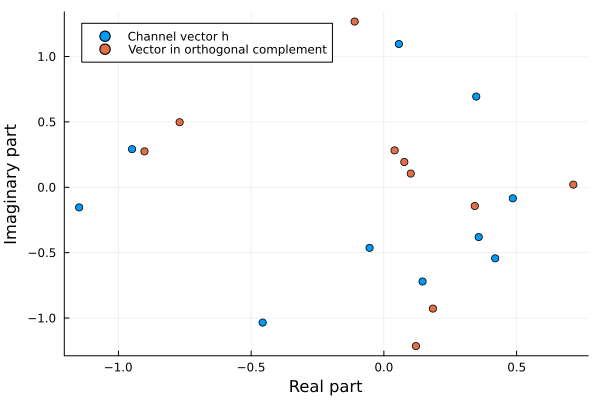

In [6]:
# Plot the vectors on the complex plane
plot(hᵣ, hᵢ
    , seriestype=:scatter
    , label="Channel vector h"
    , xlabel="Real part", ylabel="Imaginary part"
)
plot!(h˔ᵣ, h˔ᵢ
    , seriestype=:scatter
    , label="Vector in orthogonal complement"
)

In [7]:
j = √Complex(-1)

0.0 + 1.0im

In [8]:
using LaTeXStrings

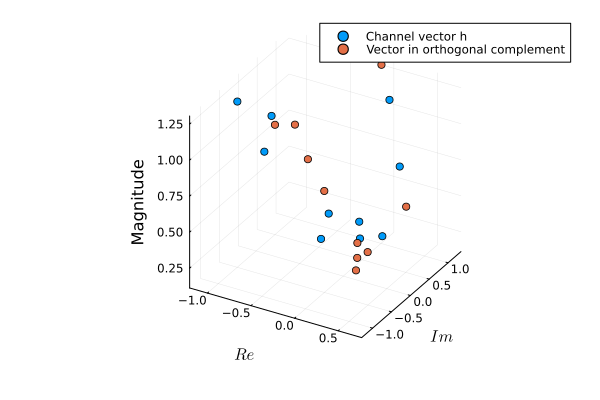

In [9]:
# Define Z coordinates based on the magnitudes of real and imaginary parts
hₔ = abs.(hᵣ  + j*hᵢ)
h˔ₔ = abs.(h˔ᵣ + j*h˔ᵢ)

# Plot the vectors in 3D
plot(hᵣ, hᵢ, hₔ
    , seriestype=:scatter3d
    , label="Channel vector h", legend=:topright
    , xlabel=L"$\scr{Re}$", ylabel=L"$\scr{Im}$", zlabel="Magnitude"
)
plot!(h˔ᵣ, h˔ᵢ, h˔ₔ
    , seriestype=:scatter3d
    , label="Vector in orthogonal complement"
)

In [10]:
𝖤 = mean

mean (generic function with 9 methods)

In [11]:
v = randn(ComplexF64, 10) # Generate a signal

# Compute autocorrelation matrix R
# 𝑅ᵥᵥ = autocorrelation_matrix(x[1:N])
N = length(v)
𝑅ᵥᵥ = [i != j ? 
        𝖤( v[ 1 : N - |(i-j) ] .* v[ |(i-j) + 1 : N] ) : # |() is the abs operator 
        𝖤(v .* v) # 𝖤 is the mean operator - Expected Value
            for i in 1:N, j in 1:N
        ];

In [12]:
# LMMSE Filter f^o
fᵒ = ((h)ᴴ * 𝑅ᵥᵥ * h˔) * ((h˔)ᴴ * 𝑅ᵥᵥ * h˔)⁻¹

1.3992583680759543 - 0.018630063316158796im

# References

##### Declare LaTeX commands
$
\DeclarePairedDelimiter{\norm}{\lVert}{\rVert}
\newcommand{\vectorproj}[2][]{\textit{proj}_{\vect{#1}}\vect{#2}}
\newcommand{\vect}{\mathbf}
$


$
  \vectorproj[\overrightarrow{v}]{\overrightarrow{a}} = \frac{\vect{a} \cdot \vect{v}}{\norm{\vect{v}}^2} \vect{v}
$


In [13]:
using RowEchelon

In [14]:
using LinearAlgebra

# Define a matrix A
A = [1 2 3; 4 5 6; 7 8 9]

# Show the matrix A
println("Matrix A:")
println(A)

# Compute the reduced row echelon form (RREF) to analyze the column space
rref_A = rref(A)

# Display the RREF of the matrix A
println("Reduced Row Echelon Form of Matrix A:")
println(rref_A)

# Define a vector b
b = [1; 1; 1]

# Check if b is a linear combination of the columns of A
# We solve Ax = b to see if a solution exists
println("Vector b:")
println(b)

if rank([A b]) == rank(A)
    solution = A \ b
    println("Vector b is in the column space of A. Solution to Ax = b:")
    println(solution)
else
    println("Vector b is not in the column space of A.")
end


Matrix A:
[1 2 3; 4 5 6; 7 8 9]
Reduced Row Echelon Form of Matrix A:
[1.0 0.0 -0.9999999999999993; 0.0 1.0 1.9999999999999998; 0.0 0.0 0.0]
Vector b:
[1, 1, 1]
Vector b is in the column space of A. Solution to Ax = b:
[0.20000000000000004, -1.4, 1.2]
